[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nrutachoudhari/AIPI590.01_Explainable_AI_Assignments/blob/main/HW5_Explainable_Deep_Learning/AIPI%20590.01%20Assignment%205.ipynb)

## AIPI 590.01 Explainable AI

### Assignment 5: Explainable Deep Learning

#### Nruta Choudhari (nmc58)

### Assignment Overview

This assignment investigates Explainable AI (XAI) within the critical domain of Public Health and Medical Diagnostics by focusing on X-ray image classification. The core objective is to analyze how a deep learning model identifies fractures and to compare the visual evidence provided by various GradCAM techniques.

1. Dataset Rationale and Details
The project utilizes the Bone Fracture Classification Dataset from Kaggle (https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset), which is composed of standard X-ray images. This dataset covers a range of bone fracture classes, such as avulsion fractures, comminuted fractures, fracture-dislocations, greenstick fractures, hairline fractures, impacted fractures, longitudinal fractures, oblique fractures, pathological fractures, and spiral fractures.

The primary significance lies in the high stakes of the task, where a misdiagnosis (either a false positive or false negative) has direct patient consequences. This context makes the model's visual reasoning (GradCAM heatmaps) a necessary check for clinical safety. Since the dataset is small (≈1,130 images), it serves as a strong test case for Transfer Learning strategies.

2. Modeling and Training Strategy
To achieve reliable predictive performance on this small dataset, we employed Transfer Learning using a VGG-19 model as the base model which has been pre-trained on ImageNet weights.
The entire convolutional backbone was initially frozen and the classification head (model.classifier) was unfrozen and retrained. This model was fine-tuned on the X-ray dataset for only 6 epochs, which was sufficient to adapt its feature extraction abilities to the medical domain and achieve functional predictive capacity for reliable XAI analysis.

In [1]:
! pip install torch torchvision grad_cam

In [ ]:
# importing the necessary libraries
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

### Loading and Preprocessing the X-ray Images

In [ ]:
# VGG-19 is the pre-trained model I have chosen for this assignment
# as VGG-19 was trained on ImageNet, defining the standard image transformations and applying normalization using ImageNet means/stds
image_size = 224
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=3),  # convert grayscale to 3-channel image
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [ ]:
# loading the full dataset
data_root = 'Bone Break Classification'
full_dataset = datasets.ImageFolder(root=data_root, transform=transform)

# determining the class names and the number of classes
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'Class names: {class_names}')
print(f'Number of classes: {num_classes}') 

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']
Number of classes: 10


In [5]:
# splitting the dataset
total_size = len(full_dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size],
                                           generator = torch.Generator().manual_seed(42))

# creating a DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Datset split: Train: {train_size}, Test: {test_size}")

Datset split: Train: 904, Test: 225


### Fine-tuning the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# loading the pre-trained VGG-19 model
# using ImageNet weights for transfer learning
model = models.vgg19(weights='IMAGENET1K_V1')

# modifying the final layer to match the number of classes in our dataset
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

model.to(device)

# freezing all convutional layers, i.e., transfer learning
for param in model.features.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

for name, module in model.features.named_children():
    # targeting the last convolutional block (block5) for unfreezing
    if int(name) >= 30: 
        for param in module.parameters():
            param.requires_grad = True
print(f"Unfroze classifier head and last convolutional block for gradient stability.")


# defining optimizer and loss function
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# performing quick fine-tuning
num_epochs = 6
train_batch_size = 32

# creating a DataLoader for the training set
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)

print(f"Starting quick fine tuning for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
print("Fine tuning completed.")


Unfroze classifier head and last convolutional block for gradient stability.
Starting quick fine tuning for 6 epochs...
Epoch 1/6, Loss: 2.5759
Epoch 2/6, Loss: 2.0922
Epoch 3/6, Loss: 1.4115
Epoch 4/6, Loss: 0.8129
Epoch 5/6, Loss: 0.6542
Epoch 6/6, Loss: 0.5903
Fine tuning completed.


In [ ]:
"""
Initially, I was getting the following error while running the CAM code:

--------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[8], line 70
     67 img_tensor = img_tensor_batch 
     68 true_label = label_batch.item()
---> 70 generate_and_display_cams(img_tensor, true_label)
     71 samples_processed += 1

Cell In[8], line 43
     39 # 3. Generate and display each CAM variant
     40 for i, (name, cam_instance) in enumerate(cam_methods.items()):
     41 
     42     # Calculate the heatmap
---> 43     grayscale_cam = cam_instance(input_tensor=input_tensor, targets=targets)[0, :]
     45     # Overlay heatmap on original image
     46     cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

File ~/miniforge3/lib/python3.12/site-packages/pytorch_grad_cam/base_cam.py:209, in BaseCAM.__call__(self, input_tensor, targets, aug_smooth, eigen_smooth)
    206 if aug_smooth is True:
    207     return self.forward_augmentation_smoothing(input_tensor, targets, eigen_smooth)
--> 209 return self.forward(input_tensor, targets, eigen_smooth)

File ~/miniforge3/lib/python3.12/site-packages/pytorch_grad_cam/base_cam.py:129, in BaseCAM.forward(self, input_tensor, targets, eigen_smooth)
    118         self.__htcore.mark_step()
    120 # In most of the saliency attribution papers, the saliency is
...
---> 23     if len(grads.shape) == 4:
     24         return np.mean(grads, axis=(2, 3))
     26     # 3D image

AttributeError: 'NoneType' object has no attribute 'shape'

Claude Sonnet 4.5 was consulted to debug this error and find the root cause. The issue was that the target layer for GradCAM was incorrectly specified, leading to gradients not being captured properly. The target layer should be a convolutional layer, but it was set to the last ReLU layer.
"""

target_layer = [model.features[-1]]  # this is the last ReLU layer

# finding the last Conv2d layer dynamically
last_conv_layer = None
for layer in reversed(model.features):
    if isinstance(layer, nn.Conv2d):
        last_conv_layer = layer
        break

if last_conv_layer is not None:
    target_layer = [last_conv_layer]
    print(f"Using target layer: {last_conv_layer}")
else:
    print("Warning: Could not find Conv2d layer, using features[-1]")
    target_layer = [model.features[-1]]

Using target layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Implementing GradCAM, GradCAM++ and XGradCAM

In [14]:
cam_methods = {
    "GradCAM": GradCAM(model=model, target_layers=target_layer),
    "GradCAM++": GradCAMPlusPlus(model=model, target_layers=target_layer),
    "XGradCAM": XGradCAM(model=model, target_layers=target_layer)
}

Generating Camps for at least 5 test samples...


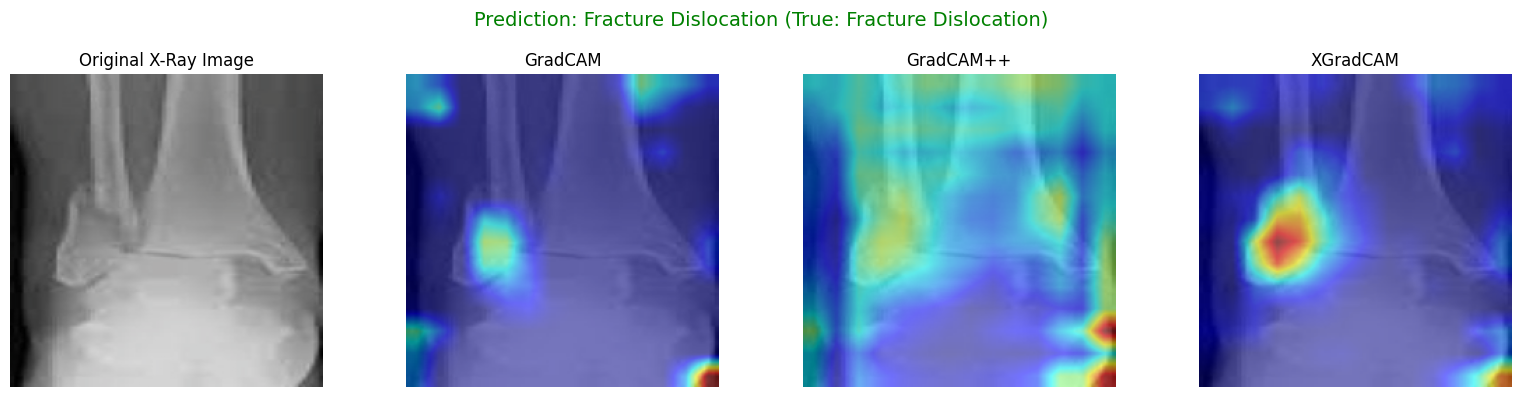

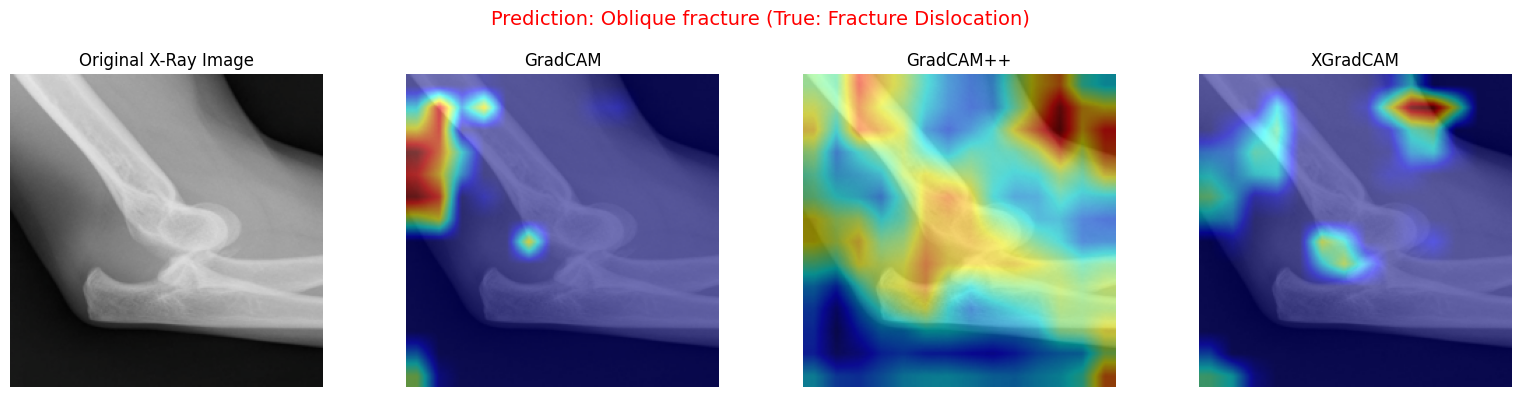

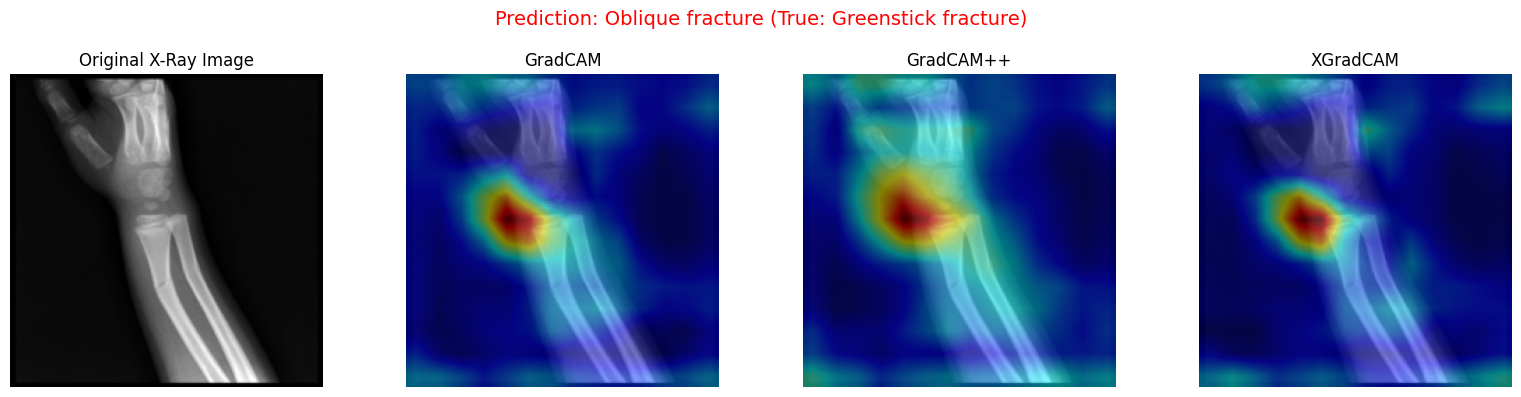

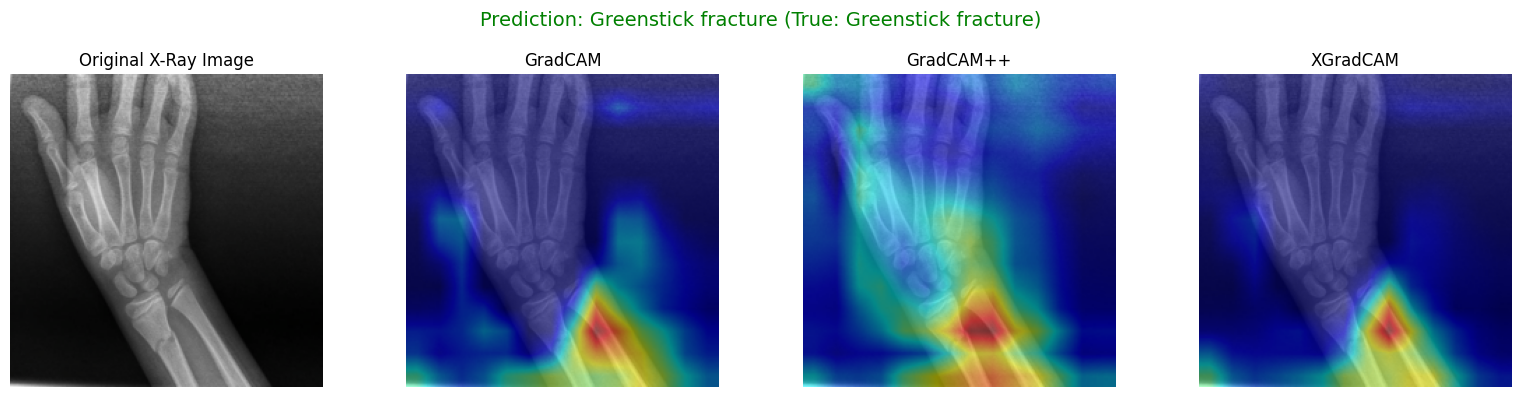

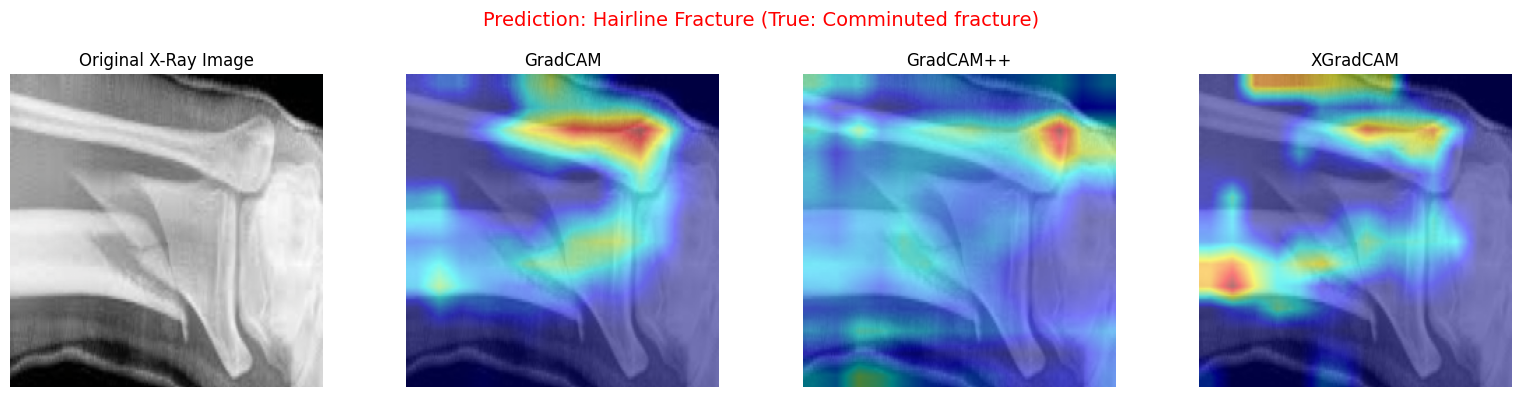

In [15]:
# generating and displaying CAMs for a few test images
print("Generating Camps for at least 5 test samples...")

# iterating over the test loader to get the required samples
requires_samples = 5
samples_processed = 0

for img_tensor_batch, label_batch in test_loader:
    if samples_processed >= requires_samples:
        break

    # processing one image at a time
    img_tensor = img_tensor_batch 
    true_label = label_batch.item()

    # un-normalizing the tensor for display
    un_norm = transforms.Normalize((-np.array(imagenet_mean) / np.array(imagenet_std)),
                                    (1.0 / np.array(imagenet_std)))
    rgb_img_tensor = un_norm(img_tensor).squeeze(0).cpu()
    rgb_img = np.transpose(rgb_img_tensor.numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    input_tensor = img_tensor.to(device)
    output = model(input_tensor)

    # getting the predicted class index
    pred_class_idx = torch.argmax(output).item()

    pred_class_name = class_names[pred_class_idx]
    true_class_name = class_names[true_label]

    # setting the target for GradCAM to be the predicted class
    targets = [ClassifierOutputTarget(pred_class_idx)]

    # setting up the visualizations
    num_methods = len(cam_methods)
    fig, axes = plt.subplots(1, num_methods + 1, figsize=(4 * (num_methods + 1), 4))

    fig.suptitle(f"Prediction: {pred_class_name} (True: {true_class_name})", fontsize = 14,
                 color = 'green' if pred_class_idx == true_label else 'red')

    # displaying th original image
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original X-Ray Image")
    axes[0].axis('off')

    # generating and displaying each CAM variant
    for i, (name, cam_instance) in enumerate(cam_methods.items()):
        # calculating the heatmap
        grayscale_cam = cam_instance(input_tensor=input_tensor, targets=targets)[0, :]

        # overlay heatmap on original image
        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        axes[i + 1].imshow(cam_image)
        axes[i + 1].set_title(name)
        axes[i + 1].axis('off')
    
    plt.tight_layout(rect = [0, 0, 1, 0.95])
    plt.show()

    samples_processed += 1

> **Image 1: Fracture Dislocation Prediction (Correct Prediction):**
> - GradCAM: It shows concentracted activation in the ankle region where the dislocation is present, with a bright yellow-green focus. However, there is noticeable cyan activation spreading to the upper left corner of the image, indicating some attention to irrelevant background areas.
> - GradCAM++: It shows a more distributed pattern with yellow-green activation across multiple areas. Although the heatmap is less focused than GradCAM, it captures more of the surrounding anatomical context of the dislocation.
> - XGradCAM: There is an intense red-yellow concentraton precisely at the fracture dislocation site. The activation is contained within the injury region with minimal background attention sites.
>
> **Image 2: Oblique Fracture Prediction (Incorrect Prediction):**
> - GradCAM: There is a bright red-yellow activation in the upper left corner of the image which is a region that contains no anatomical stuctures. There is a small cyan spot near the actual fracture site, but the model weighted the corner region more heavily.
> - GradCAM++: There are yellow-red activations scattered across the entire image which suggests that the model was highly uncertain.
> - XGradCAM: There is a cyan-yellow spot near the fracture and another activation at the top of the image. Even though it is better than GradCAM, it still shows the attention splitting between the actual fracture and the irrelevant regions, which explains the misclassifications.
>
> **Image 3: Oblique Fracture Prediction (Incorrect Prediction):**
> - GradCAM: There is an intense red-yellow activation concentration in the mid-forearm region where the greenstick fracture is visible. Although, the attention is properly localized to the fracture site, the model still misclassified it.
> - GradCAM++: It displays the same intense red-yellow focus on the greenstick fracture with a bit more spread to the surrounding areas. 
> - XGradCAM: It provides the most concentrated activation, with a red-yellow focus directly on the fracture line. So, here the attention is perfectly aligned with the fracture area, the model has confused the greenstick fracture pattern with an oblique fracture pattern.
> 
> **Image 4: Greenstick Fracture Prediction (Correct Prediction):**
> - GradCAM: It shows a cyan-green activation concentrated where the fracture is located. 
> - GradCAM++: It displays a broader yellow-red activation pattern across the fracture area, indicating that the model considered a wider anatomical context when making the correct classification.
> - XGradCAM: It concentrates a sharp yellow-red activation under the base of the hand which is more pronounced than the previous two methods.
>
> **Image 5: Hairline Fracture Prediction (Incorrect Prediction):**
> - GradCAM: It shows a strong yellow-red activation in the region of the fracture and additional cyan-green activation in other places. The model clearly detected multiple areas of abnormality but failed to combine them as signs of a complex comminuted fracture.
> - GradCAM++: It displays yellow-red activations in both the upper and lower portions of the fracture with a concentrated red spot in the middle. This distributed pattern indicates that the multiple fracture fragments were captured but the model simplified the complexity.
> - XGradCAM: Shows multiple activation sites which indicates the multiple fragments of the comminuted fracture but even then the model misinterpreted this as a simple hairline pattern.

> Across all five test samples, XGradCAM consistently produces the most spatially precise heatmaps with focused activation regions. GradCAM provides reliable but sometimes noisy visualizations while GradCAM++ generates the most distributed patterns. From these images, we can see that there is agreements amongst these variants in correct predictions while divergence in misclassifications. This indicates that consensus amongst the variants may indicate prediction confidence.
>
> The most surprising or misleading behavior occurred with Image 3. All the three GradCAM variants show intense red-yellow activation centered around the greenstick fracture. Yet, the model classified it as an oblique fracture. This shows that the model can correctly localize the issue but fail to extract the distinctive features that differentiate the fracture types.
> In Image 2, the GradCAM shows a bright red-yellow activation in a region of the X-ray image that only contains a dark background. This is concerning because it indicates that the model learned spurious correlations during training.
> In Image 5, XGradCAM showed three seperate red-yellow activation zones along the bones. Although, these correctly identify the multiple fracture fragments, the model output was a hairline fracture which was a complete misinterpretation. This indicates that the model's final classification layers failed to integrate the multi-region attention sites.
>
> Model explainability is important in medical imaging for several reasons:
> - Patient Safety: Without explainability, a clinician might accept wrong diagnosis and prescribe inappropriate treatment. Explainability allows them to verify that the model is focusing on anatomically relevant features before trusting the output, as highlighted in image 3.
> - Detecting Hidden Biases: As shown in image 2, the model learned spurious correlations with non-anatomical image features. This training artifact would have remained hidden if not for explainability.
> - Building Trust: Medical practioners distrust black-box AI systems. Having transparency in terms of explainability helps build confidence because it can show just how accurately the model is able to pick up the right areas and shows the reasoning behind a certain judgement.